# COVID-19 Prediction Model with Enhanced Techniques

In [184]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [185]:

# Definir os arquivos de treino e teste
train_files = [
    'lbp-train-fold_0.csv', 'lbp-train-fold_1.csv',
    'lbp-train-fold_2.csv', 'lbp-train-fold_3.csv', 'lbp-train-fold_4.csv'
]
test_file = 'lbp-test.csv'

# Carregar os dados de treino e concatenar em um único DataFrame
try:
    train_dfs = [pd.read_csv(file) for file in train_files]
    df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.read_csv(test_file)
except Exception as e:
    print(f"Erro ao carregar arquivos: {e}")
    exit()

# Definir as colunas de atributos e a coluna alvo
attribute_columns = [f'attribute{i}' for i in range(1, 60)]
target_column = 'class'

# Separando os atributos e a coluna alvo para treino e teste
X = df[attribute_columns]
y = df[target_column]
# Dividir o conjunto de dados com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [186]:
# Aplicar a técnica de balanceamento SMOTETomek
smotetomek = SMOTETomek(random_state=80)
X_resampled, y_resampled = smotetomek.fit_resample(X_train, y_train)


In [187]:
# Normalizar os dados
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

# Selecionar os melhores atributos com SelectKBest
k_best = 55
selector = SelectKBest(score_func=f_classif, k=k_best)
X_resampled_selected = selector.fit_transform(X_resampled, y_resampled)
X_test_selected = selector.transform(X_test)

In [188]:
print(f"Selecionados os {k_best} melhores atributos.")

# Definir a grade de parâmetros para otimização
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar o modelo base para a busca
clf = DecisionTreeClassifier(random_state=42)

# Configurar o GridSearchCV com validação cruzada estratificada e F1 Macro
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc_ovo',
    n_jobs=-1
)

# Ajustar o GridSearchCV aos dados de treino balanceados
grid_search.fit(X_resampled, y_resampled)

# Exibir os melhores parâmetros e pontuação de validação cruzada
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Melhores Parâmetros:", best_params)
print("Melhor Pontuação de Validação Cruzada:", best_score)

Selecionados os 55 melhores atributos.
Melhores Parâmetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Melhor Pontuação de Validação Cruzada: 0.9882333602279395


Random Forest Accuracy: 0.968944099378882
Random Forest F1 Score (Macro): 0.7474760222110046

Relatório de Classificação:
                                                   precision    recall  f1-score   support

                                        R/Normal       0.97      0.99      0.98       140
R/Pneumonia/Acellular/Viral/Coronavirus/COVID-19       1.00      0.85      0.92        13
    R/Pneumonia/Acellular/Viral/Coronavirus/MERS       0.00      0.00      0.00         1
    R/Pneumonia/Acellular/Viral/Coronavirus/SARS       1.00      1.00      1.00         2
           R/Pneumonia/Acellular/Viral/Varicella       0.50      1.00      0.67         1
    R/Pneumonia/Celullar/Bacterial/Streptococcus       1.00      1.00      1.00         2
        R/Pneumonia/Celullar/Fungus/Pneumocystis       1.00      0.50      0.67         2

                                        accuracy                           0.97       161
                                       macro avg       0.78      

c:\Users\X5-Melhorado\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\X5-Melhorado\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\X5-Melhorado\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

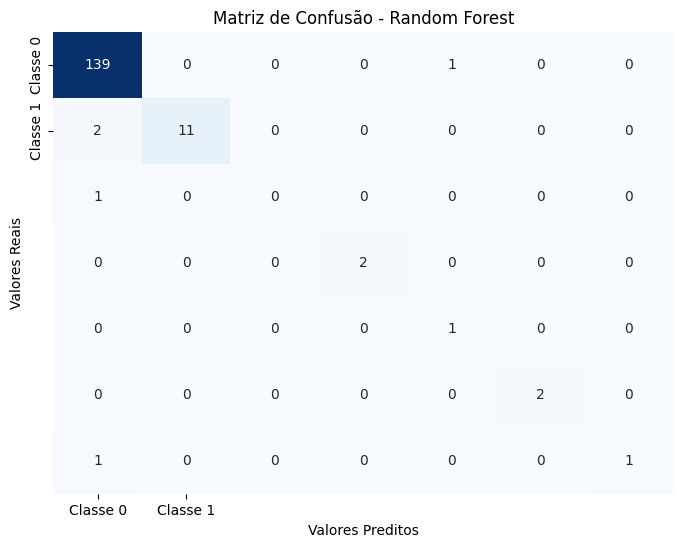

In [189]:
# Treinar Random Forest com os melhores parâmetros e pesos balanceados
rf = RandomForestClassifier(
    n_estimators=566,
    random_state=42,
    class_weight='balanced',
    **best_params
)
rf.fit(X_resampled_selected, y_resampled)

# Fazer previsões no conjunto de teste
y_pred_rf = rf.predict(X_test_selected)

# Avaliar o modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest F1 Score (Macro):", f1_macro_rf)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matriz de Confusão - Random Forest")
plt.ylabel("Valores Reais")
plt.xlabel("Valores Preditos")
plt.show()